# Data Visualization: Ford GoBike Project

## Introduction

Ford GoBike is the Bay Area's bike share system. Ford GoBike have more than 5,000 bikes and around 300 stations across San Francisco, the East Bay andand San Jose. In this project, I will explore usage of Ford GoBike during October 2018 - March 2019.

# Data Wrangling

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon

%matplotlib inline

In [2]:
# Read Ford Gobike trip history files during October 2018- March 2019
df_1904 = pd.read_csv('201904-fordgobike-tripdata.csv')
df_1903 = pd.read_csv('201903-fordgobike-tripdata.csv')
df_1902 = pd.read_csv('201902-fordgobike-tripdata.csv')
df_1901 = pd.read_csv('201901-fordgobike-tripdata.csv')
df_1812 = pd.read_csv('201812-fordgobike-tripdata.csv')
df_1811 = pd.read_csv('201811-fordgobike-tripdata.csv')
df_1810 = pd.read_csv('201810-fordgobike-tripdata.csv')

#Merge into one file
df = pd.concat([df_1904, df_1903, df_1902, df_1901, df_1812, df_1811, df_1810], sort=False)

In [3]:
df.head(5)

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip
0,50305,2019-04-30 22:33:55.1550,2019-05-01 12:32:20.4540,368.0,Myrtle St at Polk St,37.785434,-122.419622,324.0,Union Square (Powell St at Post St),37.788300,-122.408531,2749,Subscriber,1989.0,Female,No
1,53725,2019-04-30 20:43:41.6320,2019-05-01 11:39:06.9170,246.0,Berkeley Civic Center,37.869060,-122.270556,241.0,Ashby BART Station,37.852477,-122.270213,2608,Customer,NaN,NaN,No
2,78072,2019-04-30 10:32:46.4890,2019-05-01 08:13:58.9750,64.0,5th St at Brannan St,37.776754,-122.399018,64.0,5th St at Brannan St,37.776754,-122.399018,258,Subscriber,1993.0,Male,No
3,78969,2019-04-30 10:00:51.5500,2019-05-01 07:57:01.2620,67.0,San Francisco Caltrain Station 2 (Townsend St...,37.776639,-122.395526,89.0,Division St at Potrero Ave,37.769218,-122.407646,1974,Subscriber,1972.0,Male,No
4,1128,2019-04-30 23:59:04.7390,2019-05-01 00:17:53.0910,124.0,19th St at Florida St,37.760447,-122.410807,5.0,Powell St BART Station (Market St at 5th St),37.783899,-122.408445,877,Subscriber,1973.0,Male,No


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1337860 entries, 0 to 201457
Data columns (total 16 columns):
duration_sec               1337860 non-null int64
start_time                 1337860 non-null object
end_time                   1337860 non-null object
start_station_id           1335098 non-null float64
start_station_name         1335098 non-null object
start_station_latitude     1337860 non-null float64
start_station_longitude    1337860 non-null float64
end_station_id             1335098 non-null float64
end_station_name           1335098 non-null object
end_station_latitude       1337860 non-null float64
end_station_longitude      1337860 non-null float64
bike_id                    1337860 non-null int64
user_type                  1337860 non-null object
member_birth_year          1278190 non-null float64
member_gender              1278207 non-null object
bike_share_for_all_trip    1337860 non-null object
dtypes: float64(7), int64(2), object(7)
memory usage: 173.5+ MB


## What is the structure of your dataset?

There are around 1.3 millions bike rides in the dataset with 16 features. Most variables are numeric variables which are about the start and end station mark, id, duration per trip, start time, end time, bike id, and member birth year. Categorical variables are start and end station id, user type, member gender, and bike share for all trip.

## What is/are the main feature(s) of interest in your dataset?

I want to find the connection between characteristic of main customers (i.e. age, gender, user type, and location) and their behaviour of bike usage (i.e. bike for all trip, duration use, the peak hour use of a day, usage in day of week (weekday and weekend), usage in each city, the trend of bike ride growth in previous 7 months, the popular start and end station, and the popular route)

## What features in the dataset do you think will help support your investigation into your feature(s) of interest?

I assume some charateristic traits could affect customer behaviours; for example, if our main customers were teenagers or adults, they would ride a bike for travelling to work which impact the peak hour usage of a day is a rush hour. I also think gender and user type may have small effects to bike rides behaviour.

#### Then, I will add some features (i.e. user age, duration minute, and day of week) to help us explore the detail of investigation, and I will drop some features that will not be used

In [5]:
# 1. Calculate duration_minute from duration_sec

def cal_minute(sec):
    return sec / 60 

df.loc[:, 'duration_minute']= df['duration_sec'].aggregate(cal_minute)

In [6]:
# 2.  Day of week
## Change the start_time datatype into datetime
df.start_time = pd.to_datetime(df.start_time)

def day(time):
    return time.dt.day_name()

df.loc[:, 'day_of_week']= df['start_time'].aggregate(day)

In [7]:
##  Day of week in order
day_classes = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dayclasses = pd.api.types.CategoricalDtype(ordered = True, categories = day_classes)
df.day_of_week = df.day_of_week.astype(dayclasses);

In [8]:
# 3. Month in order
df = df.assign(month = df.start_time.dt.month)

In [9]:
## Month in order
month_classes = [10, 11, 12, 1, 2, 3, 4]
monthclasses= pd.api.types.CategoricalDtype(ordered = True, categories = month_classes)
df.month = df.month.astype(monthclasses);

In [10]:
# 4. Query the time (hour of day)
df = df.assign(hour_of_day = df.start_time.dt.hour)

In [11]:
# 5. Calculate customers age
from datetime import date

def calculate_age(born):
    return 2019 - born

df.loc[:, 'user_age']= df['member_birth_year'].aggregate(calculate_age)

In [12]:
# 6. User age group

def age_groups(age):
    if age >= 58:
        return 'above 58'
    elif age >= 48:
        return 'age 48-57'
    elif age >= 38:
        return 'age 38-47'
    elif age >= 28:
        return 'age 28-37'
    elif age >= 18:
        return 'age 18-27'
    else:
        return 'NaN'

In [13]:
df.loc[:, 'user_age_group']= df['user_age'].aggregate(age_groups)

In [14]:
## Age in order
age_classes = ['age 18-27', 'age 28-37', 'age 38-47', 'age 48-57', 'above 55', 'NaN']
ageclasses = pd.api.types.CategoricalDtype(ordered = True, categories = age_classes)
df.user_age_group = df.user_age_group.astype(ageclasses);

In [15]:
# 7. Find out the city from start station name, I decide to focus on San Francisco so East bay and San Jose will be query into 'Other'. 
#I assume start station represent the bike usage in each city

def town(dataframe):
    town = pd.Series()
    for index, row in df.iterrows():
        if 37.708457 <= row['start_station_latitude'] <=37.810672 and  -122.501018 <= row['start_station_longitude'] <= -122.354742 :
            town.at[index] = 'San Francisco'
        else:
            town.at[index] = 'Other'
    return town

In [16]:
df = df.assign(start_city =town(df))

In [17]:
df.drop(columns = ['start_station_id', 'start_station_latitude', 'start_station_longitude', 'end_station_id', 'end_station_latitude','end_station_longitude', 'member_birth_year'], inplace = True)

In [18]:
df.to_csv('ford_gobike_clean.csv', index = False)

In [19]:
df.head()

,duration_sec,start_time,end_time,start_station_name,end_station_name,bike_id,user_type,member_gender,bike_share_for_all_trip,duration_minute,day_of_week,month,hour_of_day,user_age,user_age_group,start_city
0,50305,2019-04-30 22:33:55.155,2019-05-01 12:32:20.4540,Myrtle St at Polk St,Union Square (Powell St at Post St),2749,Subscriber,Female,No,838.416667,Tuesday,4,22,30.0,age 28-37,San Francisco
1,53725,2019-04-30 20:43:41.632,2019-05-01 11:39:06.9170,Berkeley Civic Center,Ashby BART Station,2608,Customer,NaN,No,895.416667,Tuesday,4,20,NaN,NaN,San Francisco
2,78072,2019-04-30 10:32:46.489,2019-05-01 08:13:58.9750,5th St at Brannan St,5th St at Brannan St,258,Subscriber,Male,No,1301.200000,Tuesday,4,10,26.0,age 18-27,San Francisco
3,78969,2019-04-30 10:00:51.550,2019-05-01 07:57:01.2620,San Francisco Caltrain Station 2 (Townsend St...,Division St at Potrero Ave,1974,Subscriber,Male,No,1316.150000,Tuesday,4,10,47.0,age 38-47,San Francisco
4,1128,2019-04-30 23:59:04.739,2019-05-01 00:17:53.0910,19th St at Florida St,Powell St BART Station (Market St at 5th St),877,Subscriber,Male,No,18.800000,Tuesday,4,23,46.0,age 38-47,Other


# Exploratory Data Analysis

## Univariate Exploration

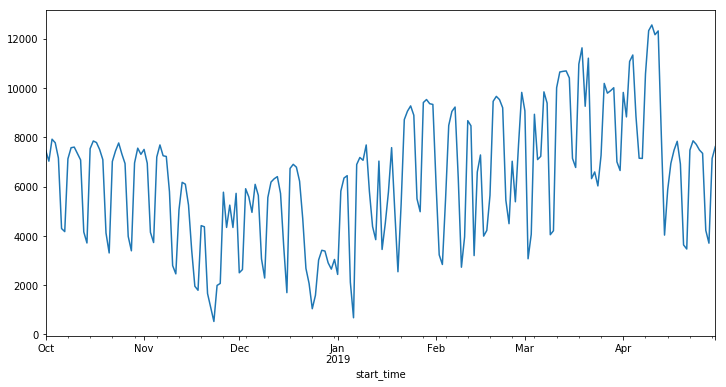

In [20]:
# I will start with the growth in number of bike rides from October 2018- March 2019
df.groupby(df.start_time.dt.to_period('D')).agg('count')['bike_id'].plot(kind = 'line', figsize = [12, 6]);

- The trend of bike rides during November - December were decreased maybe because of weather. In addtion, there is weekly trend fluctuated; for example,  it was lower than 2,000 in the end of November. After January the number of ride bikes gradually increased, and the highest value was more than 10,000. However, a graph was suddenly dorpped in mid-april. The causation maybe Ford GoBike suspended electric-assist bike service after braking issues in mid-april. 

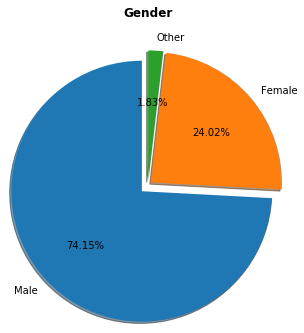

In [21]:
# Gender percentage
count_gender = df.member_gender.value_counts()

count_gender.plot(kind="pie",  startangle=90, shadow=True, explode=(0.1, 0.05, 0.05), autopct='%1.2f%%', radius = 1.5)
plt.title("Gender\n\n", fontweight ='bold', pad=30)
plt.ylabel("");

- Male have the highest percentages which are 74.23%.

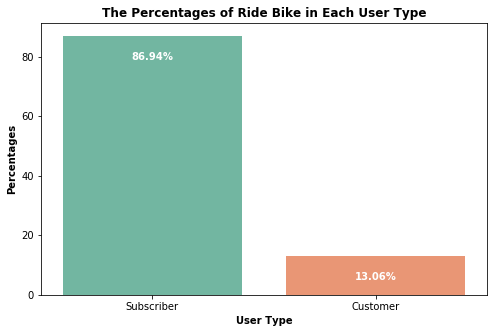

In [22]:
# User type percentages
count_type = df.user_type.value_counts() / df.user_type.count() *100

plt.figure(figsize = [8, 5])

sb.barplot(count_type.index.values, count_type, palette = 'Set2')
plt.title('The Percentages of Ride Bike in Each User Type', fontweight ='bold')
plt.xlabel('User Type', fontweight ='bold')
plt.ylabel('Percentages', fontweight ='bold')

# add annotations
n_points = df.shape[0]
locs, labels = plt.xticks() 

# loop through each pair of locations and labels
for loc, label in zip(locs, labels):

    # get the text property for the label to get the correct count
    count = count_type[label.get_text()]
    pct_string = '{:0.2f}%'.format(count)

    # print the annotation just below the top of the bar
    plt.text(loc, count -8, pct_string, ha = 'center', color = 'w', fontweight ='bold');

- Subscriber have the highest percentages which are 86.94%.

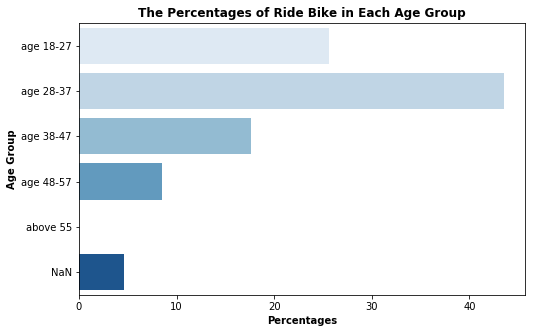

In [23]:
# Age group percentages
count_age = df.user_age_group.value_counts() / df.user_age_group.count() *100
count_age = count_age.reset_index(name='percentages') 

plt.figure(figsize = [8, 5])

sb.barplot(data =count_age, x= 'percentages', y = 'index', palette = 'Blues')
plt.title('The Percentages of Ride Bike in Each Age Group', fontweight ='bold')
plt.xlabel('Percentages', fontweight ='bold')
plt.ylabel('Age Group', fontweight ='bold');

- The first and the second age group that have highest percentages are age 28-37, and age 18-27 respectively.

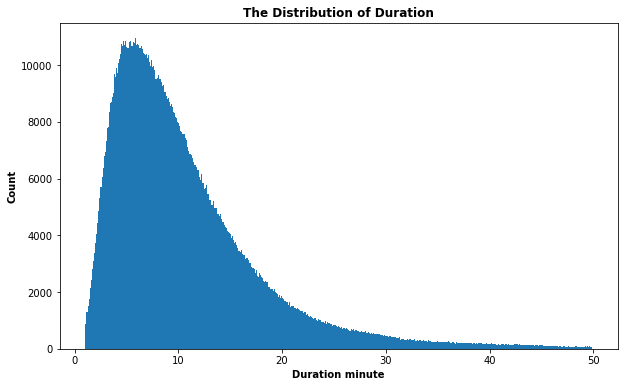

In [24]:
#  Duration_minute
plt.figure(figsize = [10, 6])

bin_edges = np.arange(1, 50, 0.1)
plt.hist( data = df, x = 'duration_minute', bins = bin_edges)
plt.title('The Distribution of Duration', fontweight ='bold')
plt.xlabel('Duration minute', fontweight ='bold')
plt.ylabel('Count', fontweight ='bold');

- Most customers spend times around 10 minutes per trip. It is possible that they used it to travel a near place. 

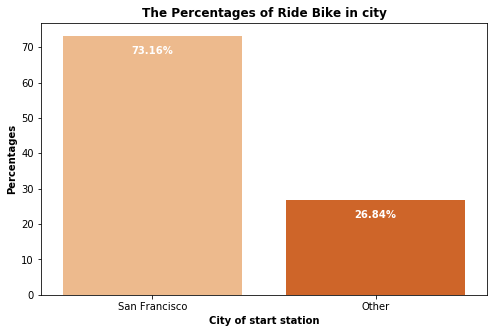

In [26]:
# Start station city percentages
per_city = df.start_city.value_counts() / df.start_city.count() *100

plt.figure(figsize = [8, 5])

sb.barplot(per_city.index.values, per_city, palette = 'Oranges')
plt.title('The Percentages of Ride Bike in city', fontweight ='bold')
plt.xlabel('City of start station', fontweight ='bold')
plt.ylabel('Percentages', fontweight ='bold')

# add annotations
n_points = df.shape[0]
locs, labels = plt.xticks() 

# loop through each pair of locations and labels
for loc, label in zip(locs, labels):

    # get the text property for the label to get the correct count
    count = per_city[label.get_text()]
    pct_string = '{:0.2f}%'.format(count)

    # print the annotation just below the top of the bar
    plt.text(loc, count -5, pct_string, ha = 'center', color = 'w', fontweight ='bold');

- The percenatges of bike ride in San Francisco (73.16%) are higher than other city(26.84%). 

In [27]:
# The most popular start station
start_station = df.start_station_name.value_counts().reset_index(name='counts').sort_values('counts', ascending=False).head(10)

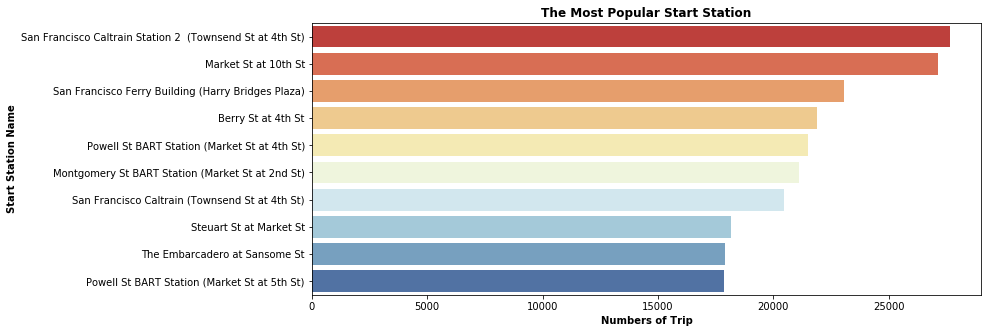

In [28]:
plt.figure(figsize = [12, 5])

sb.barplot(data = start_station, x= 'counts', y = 'index', palette = 'RdYlBu')
plt.title('The Most Popular Start Station', fontweight ='bold')
plt.xlabel('Numbers of Trip', fontweight ='bold')
plt.ylabel('Start Station Name', fontweight ='bold');

In [29]:
# The most popular end station
end_station = df.end_station_name.value_counts().reset_index(name='counts').sort_values('counts', ascending=False).head(10)

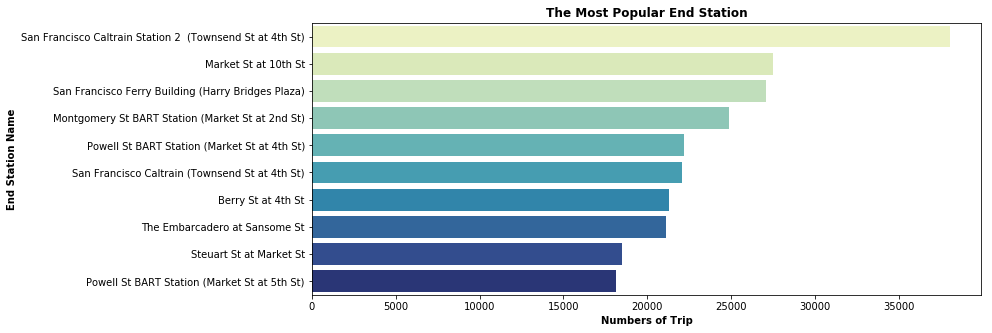

In [30]:
plt.figure(figsize = [12, 5])

sb.barplot(data = end_station, x= 'counts', y = 'index', palette = 'YlGnBu')
plt.title('The Most Popular End Station', fontweight ='bold')
plt.xlabel('Numbers of Trip', fontweight ='bold')
plt.ylabel('End Station Name', fontweight ='bold');

- The top 3 start and end station are the same lists which are San Francisco Caltrain Station 2 (Townsend St at 4th St), Market St at 10th St, and San Franciso Ferry Building (Harry Bridges Plaza). In addtion, most stations from both lists are near San Francisco train station or located on Market street.

## Bivariate Exploration

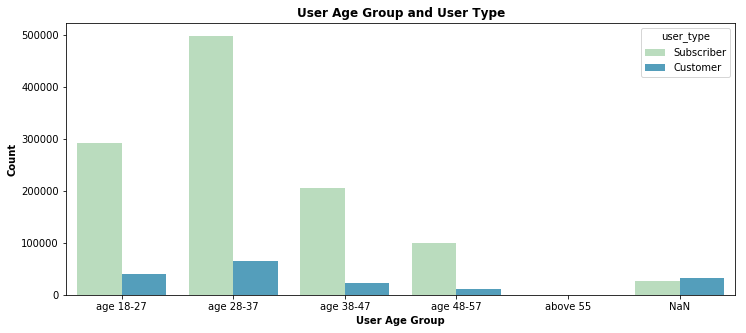

In [31]:
# Let's see the see the number of each user age group that are sorted by user type

plt.figure(figsize = [12, 5])

sb.countplot(data = df, x = 'user_age_group', hue = 'user_type', palette = 'GnBu')
plt.title('User Age Group and User Type', fontweight ='bold')
plt.xlabel('User Age Group', fontweight ='bold')
plt.ylabel('Count', fontweight ='bold');

- The majority of users are subscriber. 
- Age 28 - 37 has a highest times of bike rides.

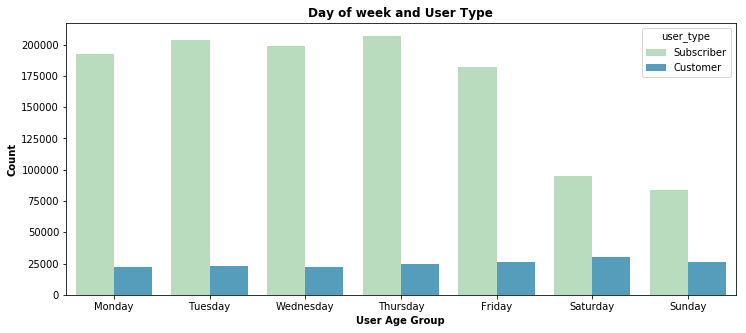

In [37]:
# Then, I want to know subscriber and customer have any different trend of using Ford Gobike service in each day of week

plt.figure(figsize = [12, 5])

sb.countplot(data =df, x= 'day_of_week', hue = 'user_type',  palette = 'GnBu')
plt.title('Day of week and User Type', fontweight ='bold')
plt.xlabel('User Age Group', fontweight ='bold')
plt.ylabel('Count', fontweight ='bold');

- Subscriber demand of bicycles is high during Monday - Friday (Weekday) and is largely decreased on Saturday and Sunday (Weekend). On the other hand, customer's usage is almost the same number in each day.

In [33]:
# Age and Day of week
day_age_counts = df.groupby(['day_of_week', 'user_age_group']).size().reset_index(name = 'count')
day_age_counts  = day_age_counts .pivot(index= 'day_of_week', columns = 'user_age_group', values = 'count') 

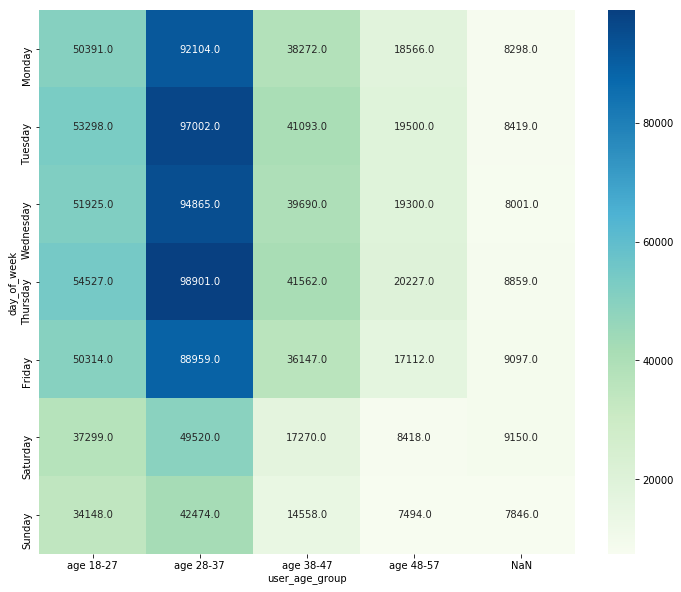

In [34]:
plt.figure(figsize = [12, 10])

sb.heatmap(day_age_counts , annot=True, fmt=".1f", cmap="GnBu");

- All user age group have more number of rides in weekdays (especially on Thursday) than in weekends.

In [35]:
# User type and hour of day
user_hour_counts  = df.groupby(['hour_of_day', 'user_type']).size()
user_hour_counts  =user_hour_counts.reset_index(name = 'count')

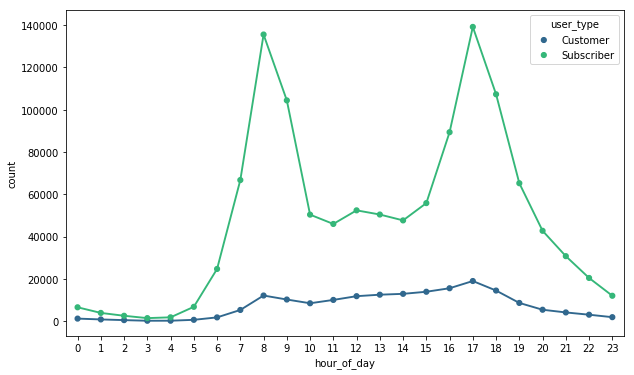

In [36]:
plt.figure(figsize = [10, 6])

ax = sb.pointplot(x='hour_of_day', y='count', hue='user_type', scale=.7, data= user_hour_counts, palette = 'viridis')

- Subscriber lines has peaks at 8am and 5pm, while customer line steadily for all day.

In [38]:
# Day of week and Hour of day
day_hour_counts = df.groupby(['day_of_week', 'hour_of_day']).size()
day_hour_counts = day_hour_counts.reset_index(name = 'count')

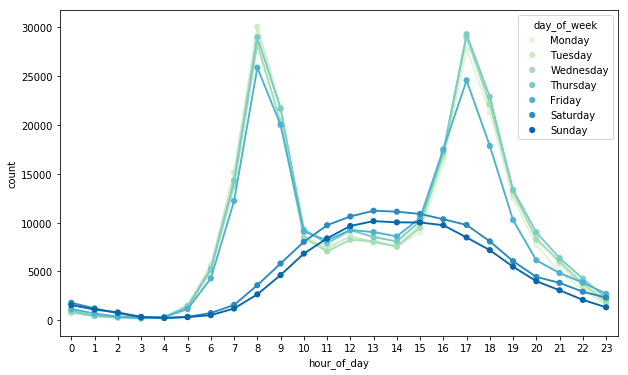

In [39]:
plt.figure(figsize = [10, 6])

ax = sb.pointplot(x='hour_of_day', y='count', hue= 'day_of_week', scale=.7, data= day_hour_counts, palette = 'GnBu')

- Let's check out which the peak time of a day, there are two patterns in the graph: a weekday and a weekend pattern. The peak of weekday lines are around 8am and 5pm. Compare to the weekday lines, the weekend lines are significantly lower and they look like a bell curve (popular time is around 10am-7pm). 

In [40]:
# Explore the duration minutes on each day in total
sum_duration_hour = df.groupby('hour_of_day').duration_minute.sum().reset_index()

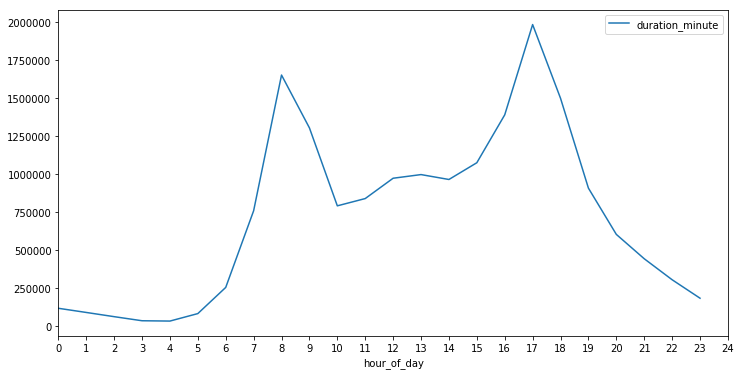

In [41]:
xticks = np.arange(25)
sum_duration_hour.plot.line(x= 'hour_of_day', y= 'duration_minute', xticks = xticks, figsize = [12,6]);

- The time spend graph has an exact the same pattern as the previous graph(time of bike ride during weekday). Users mostly rent a bike from a start station around 8am and 5pm so it make the sum of duration at that time more than 1,200,000 minutes.

In [42]:
#But how about duration minutes in average 
ave_dura_each_min = df.groupby('hour_of_day').duration_minute.mean().reset_index()

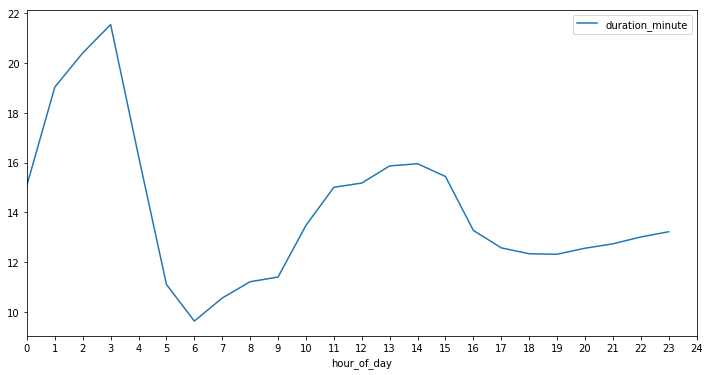

In [43]:
xticks = np.arange(25)
ave_dura_each_min.plot.line(x= 'hour_of_day', y= 'duration_minute', xticks = xticks, figsize = [12,6]);

- Surprisingly, the longest duration trip in average is at around 3am, while users spend only around 10 minutes per trip during 6am- 9am. In summary, even though the highest number of usage is at 8am, users spend a short time (around 11 minutes) per trip and it is possible they ride a bike for a near place.

In [44]:
# User types and Duration minute
ave_duration_user = df.groupby('user_type').duration_minute.mean().reset_index()

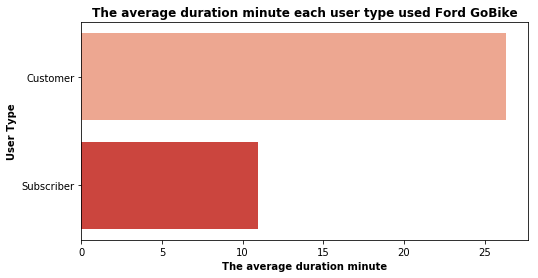

In [45]:
plt.figure(figsize = [8, 4])

sb.barplot(data = ave_duration_user, x= 'duration_minute', y = 'user_type', palette = 'Reds')
plt.title('The average duration minute each user type used Ford GoBike', fontweight ='bold')
plt.xlabel('The average duration minute', fontweight ='bold')
plt.ylabel('User Type', fontweight ='bold');

- Surprisingly, customers tend to spend more time using a bike in average than subscribers around 15 minutes. 

In [46]:
# Let's go deep into detail: a day of week
ave_duration_day_of_week= df.groupby(['day_of_week', 'user_type']).duration_minute.mean().reset_index()

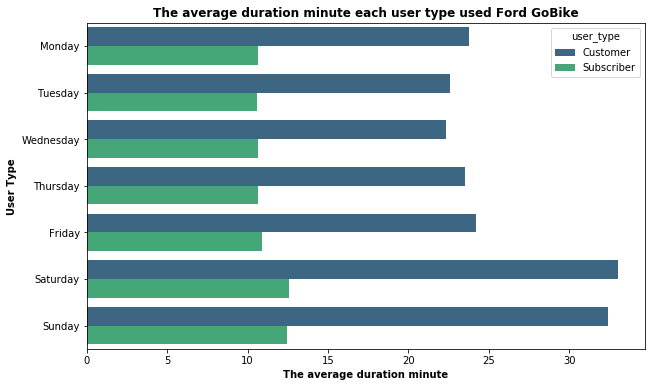

In [47]:
plt.figure(figsize = [10, 6])

sb.barplot(data = ave_duration_day_of_week, x= 'duration_minute', y = 'day_of_week', hue = 'user_type', palette = 'viridis')
plt.title('The average duration minute each user type used Ford GoBike', fontweight ='bold')
plt.xlabel('The average duration minute', fontweight ='bold')
plt.ylabel('User Type', fontweight ='bold');

- Customers spend longer times than subscribers in everyday.
- The average of duration minutes of subscribers are almost the same value on each day.
- Customers tend to spend longest duration in average during weekend which are arond 30 minutes.

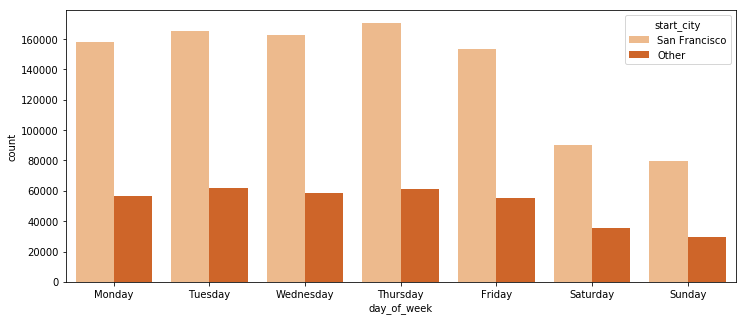

In [48]:
plt.figure(figsize = [12, 5])

base_color = sb.color_palette()[0]
sb.countplot(data = df, x = 'day_of_week', hue = 'start_city', palette = 'Oranges');

In [49]:
# The growth of bike rides San Francisco Vs. Other city
town_month_counts  = df.groupby(['month', 'start_city']).size()
town_month_counts  = town_month_counts.reset_index(name = 'count')

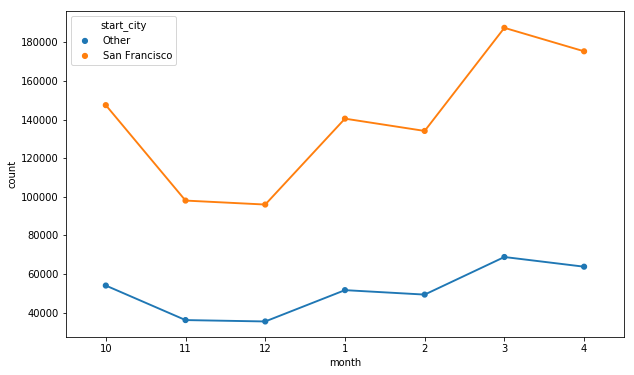

In [50]:
plt.figure(figsize = [10, 6])

ax = sb.pointplot(x='month', y='count', hue='start_city', scale=.7, data= town_month_counts)

- San Francisco has a highest rides.
- San Francisco has a largely fluctuated when something happens San Francisco get the most impacts. 

In [51]:
# Start town and Hour of day
town_hour_counts  = df.groupby(['hour_of_day', 'start_city']).size()
town_hour_counts  = town_hour_counts.reset_index(name = 'count')

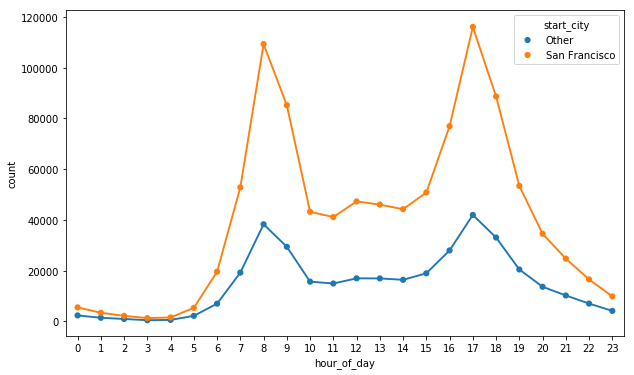

In [52]:
plt.figure(figsize = [10, 6])

ax = sb.pointplot(x='hour_of_day', y='count', hue='start_city', scale=.7, data= town_hour_counts)

- Both start towns have the same pattern of the peak time of rides which are 8am and 5pm.

In [53]:
# The most popular route
popular_route = df.groupby(['start_station_name', 'end_station_name']).size().reset_index(name='counts').sort_values('counts', ascending=False).head(10)

In [54]:
popular_route['route'] = popular_route[['start_station_name', 'end_station_name']].apply(lambda x: '-'.join(x), axis=1) 

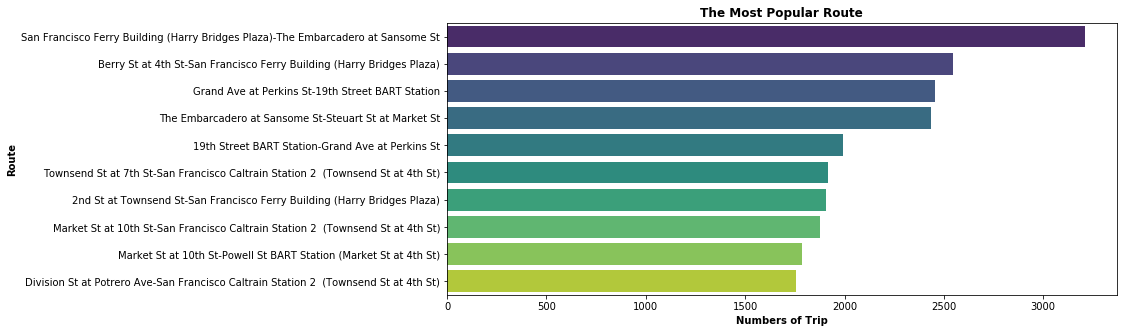

In [55]:
plt.figure(figsize = [12, 5])

sb.barplot(data = popular_route, x= 'counts', y = 'route', palette = 'viridis')
plt.title('The Most Popular Route', fontweight ='bold')
plt.xlabel('Numbers of Trip', fontweight ='bold')
plt.ylabel('Route', fontweight ='bold');

- The most popular route is San Francisco Ferry Building (Harry Bridges Plaza) to The Embarcadero at Sansome St which are in the recommendation route by the Ford Gobike website. 

**The relationship of Bivariate Exploration**

1. The majority of users are 28-37 years old and most of them are subscriber. Compare both characteristic to day of week, I find out that all user age group and the subscriber use Ford Gobike in the weekend more than in the weekend. While minority customer have the similar number of usage in each day.

2. Analyzing the trend of peak hour of day, the weekday and subscriber have the same trends which its peak at 8am and 5pm. Due to the peak hour, I assume that Ford Gobike's subscribers are employees, which link to previous insight that the customers are mostly 28-37 years old. They use a bike for traveling between home and work which make the peak time at 8am and 5pm. 

3. Although the highest number of usage is at 8am, users spend a short time (around 11 minutes) per trip and it is possible they ride a bike to a near place like travel between the main train station and town ( which popular start and end station are located there). This pattern also similar to average duration that subscriber spend in each day (around 10 minutes). While casual customers seem to spend time more than 20 minutes on average in each trip especially on the weekend.

4. San Francisco and other city have the same pattern of  growth trend from October 2018 - April 2019 and the hour of day.

5. The most popular route is San Francisco Ferry Building (Harry Bridges Plaza) to The Embarcadero at Sansome St which are in the recommendation route by the Ford Gobike website. It is a route that user can enjoy the view of the Bay and the largest farmer's market in town. However, I am surprised that San Francisco Caltrain Station 2 (Townsend St at 4th St) and Market St at 10th St (top 2 popular start and end station) are  in the eighth and nineth popular route.

## Multivariate Exploration

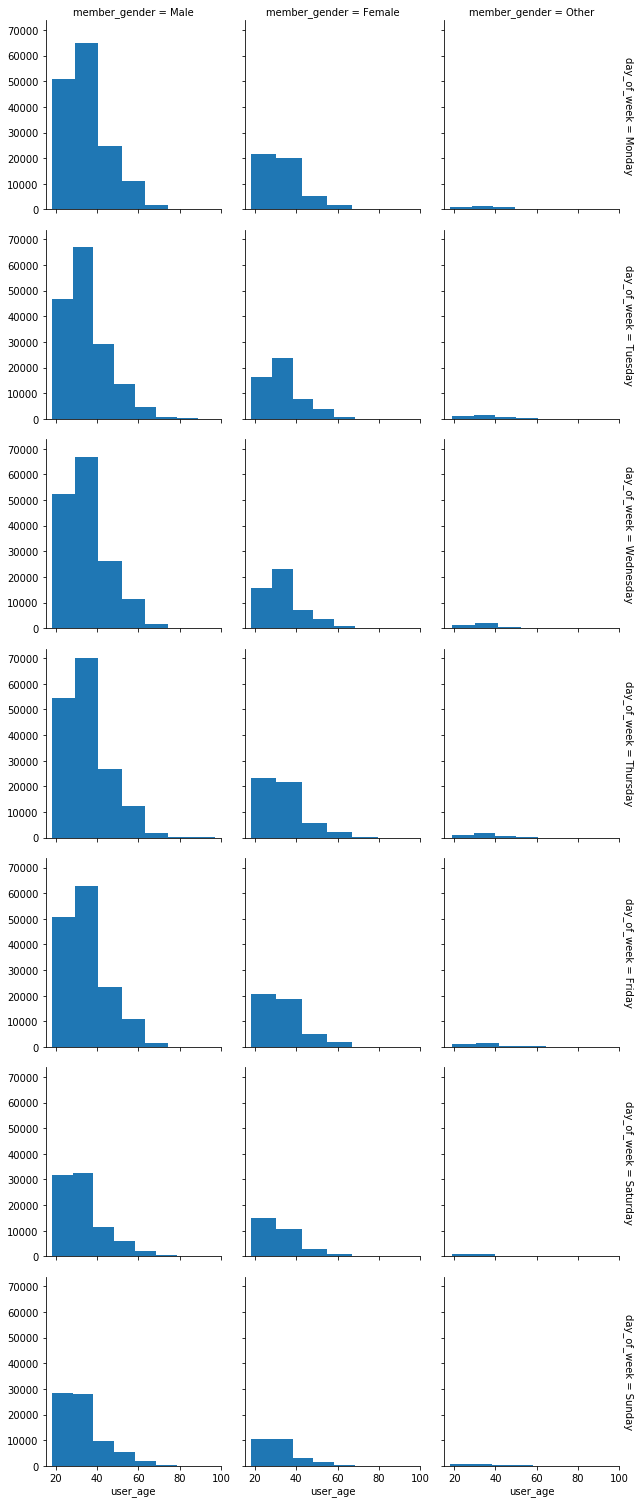

In [56]:
# Member gender, Day of week, and user age
base_color = sb.color_palette()[0]
g = sb.FacetGrid(df, col="member_gender", col_order=["Male", "Female", "Other"], row="day_of_week",
                margin_titles = True)
plt.xlim(15,100)
g = g.map(plt.hist, "user_age", color= base_color)

- In the weekdays, male and female chart has the same age and number of rides pattern. In addition, male age around 28-34 has the highest number of rides.
- In the weekend, all gender and age are drop.

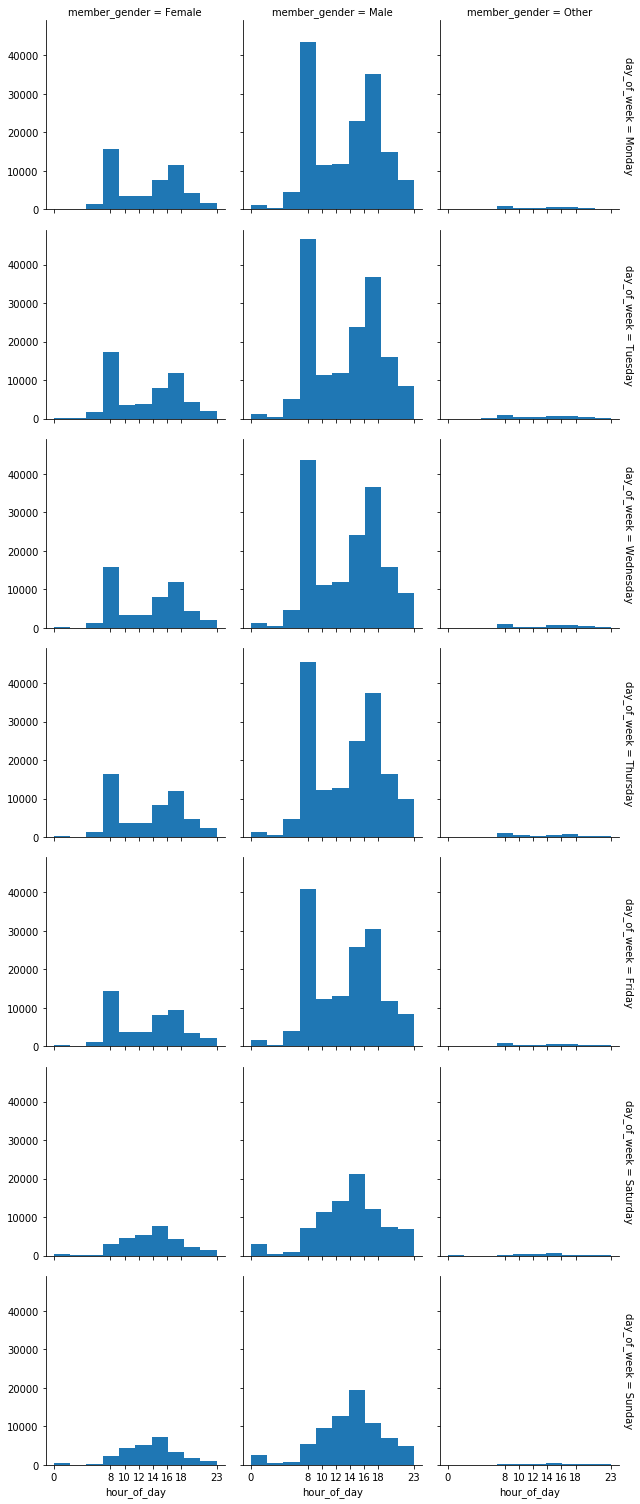

In [57]:
base_color = sb.color_palette()[0]
g = sb.FacetGrid(df, col="member_gender" , row="day_of_week", margin_titles = True)
g.set(xticks = [0, 8, 10, 12, 14, 16, 18, 23])
g = g.map(plt.hist, 'hour_of_day', color= base_color);

- It could be seen that male and female have the similar patterns in each day (except male has a lager number of usage than female).
- We can divide the hour of day and day of week into 2 patterns like we've already known (weekday is peak at 8am and 5pm, and weekend is around aafternoon)

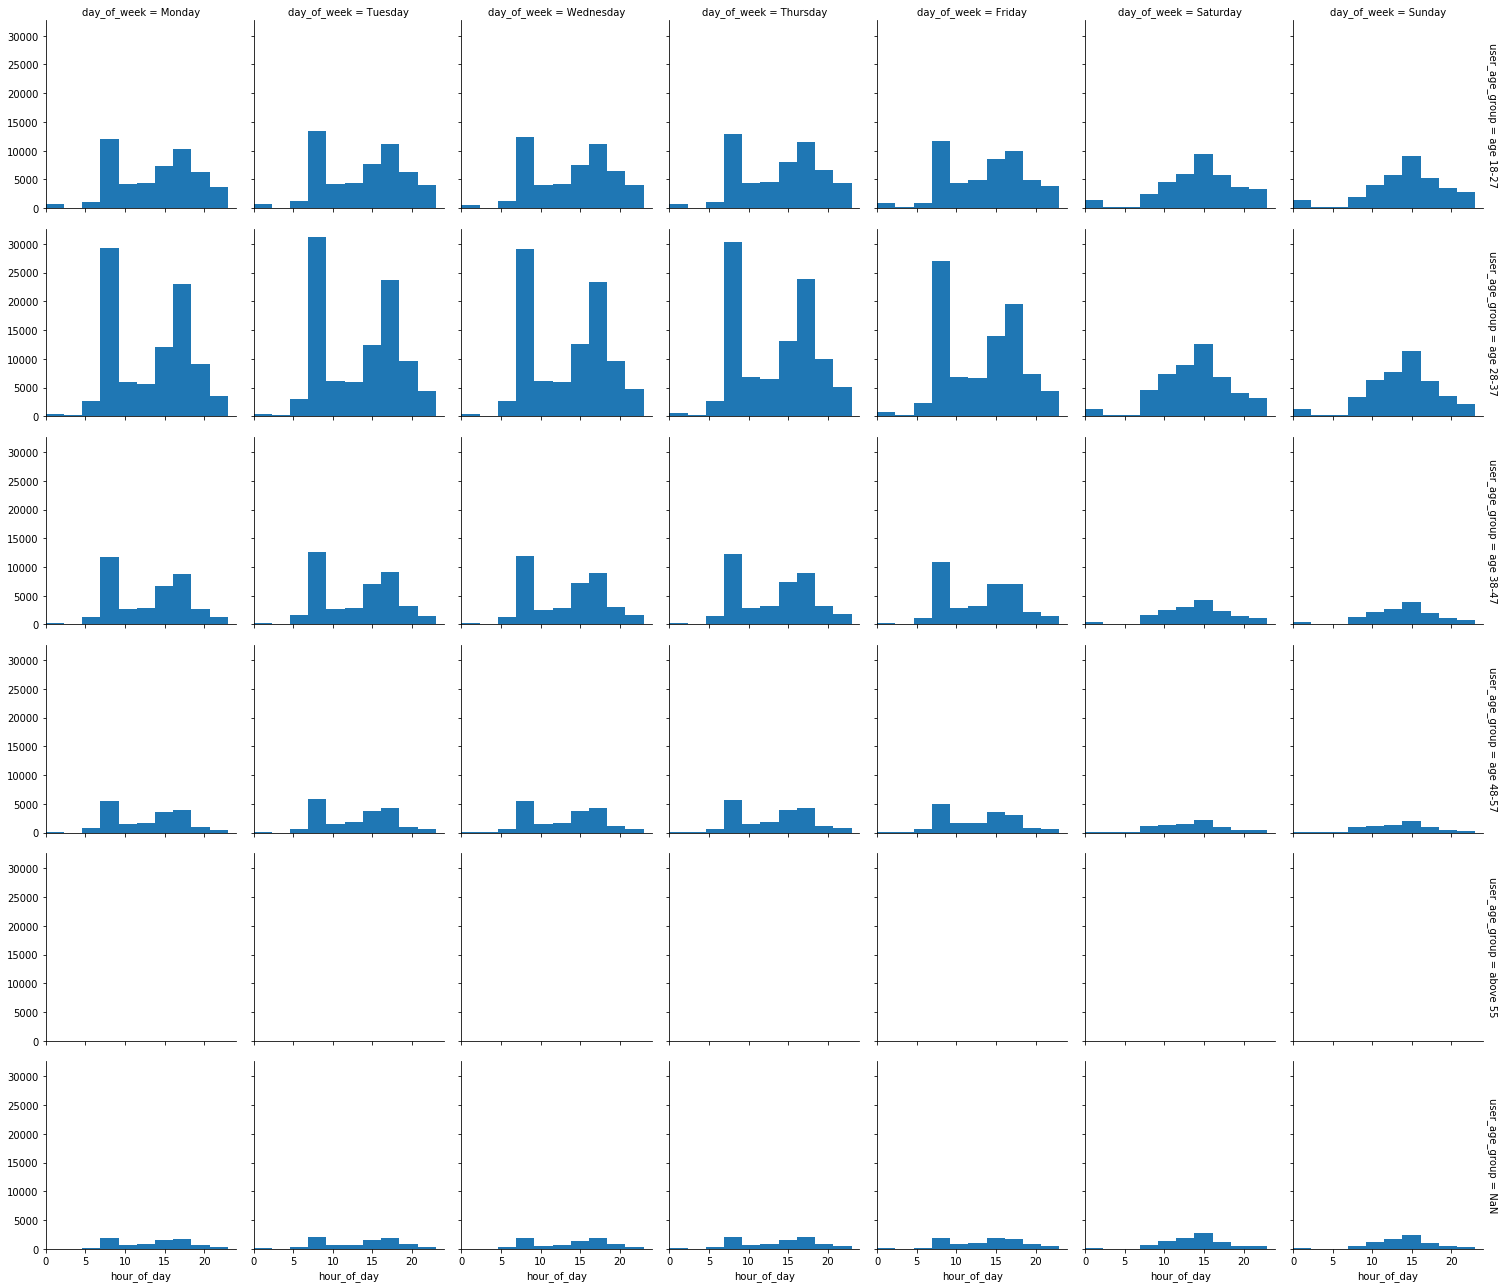

In [58]:
base_color = sb.color_palette()[0]
g = sb.FacetGrid(df, col='day_of_week' , row= 'user_age_group', margin_titles = True)
plt.xlim(0,24)
g = g.map(plt.hist, 'hour_of_day', color= base_color)

- It shows that the peak hour of rides between male and female for each days are similar (except male has a lager number of usage than female).
- We can divide the peak time into 2 patterns : weekday is peak at 8am and 5pm, and weekend is around afternoon.

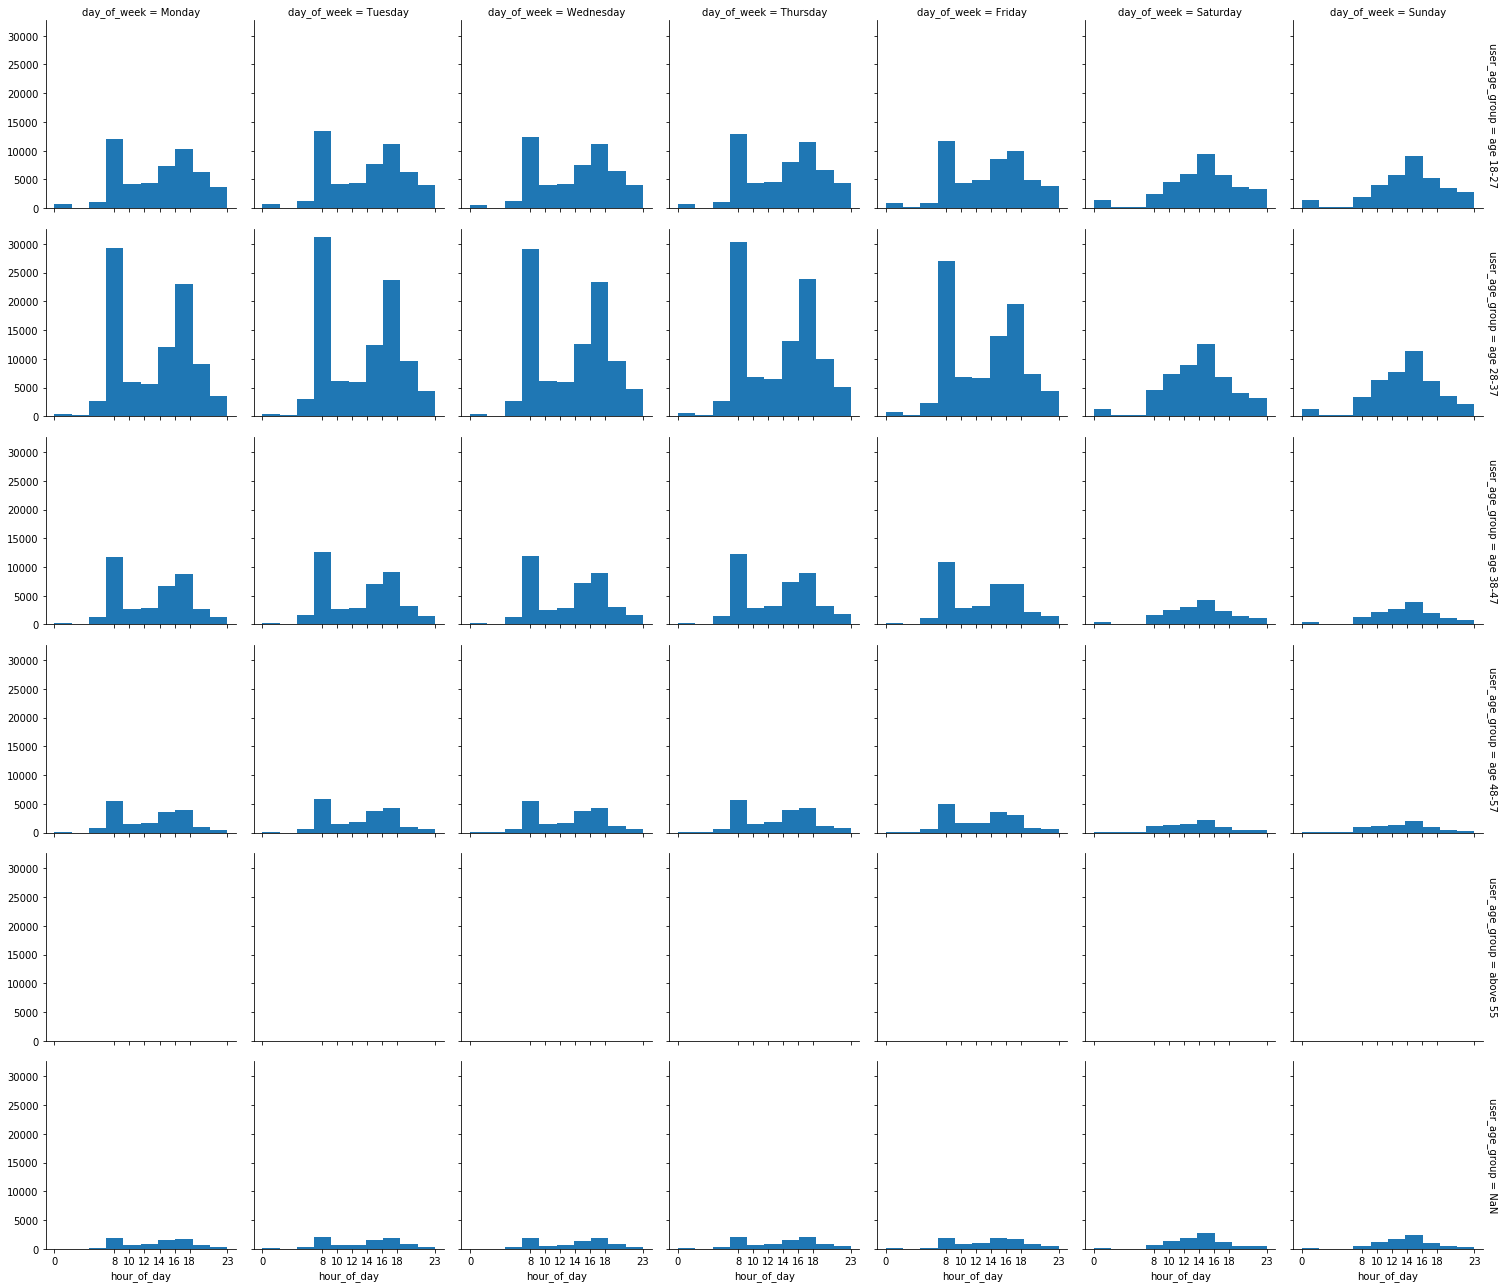

In [59]:
base_color = sb.color_palette()[0]
g = sb.FacetGrid(df, col='day_of_week' , row= 'user_age_group',
                margin_titles = True)
g.set(xticks = [0, 8, 10, 12, 14, 16, 18, 23])
g = g.map(plt.hist, 'hour_of_day', color= base_color);

- All user age group have the same peak time for each day.
- If we divided days into weekday and weekend, we can see that all age group have the same amout of rides in each hour of day. Or we could says that bike rides is kind of a daily routine transportation of whole age group users.

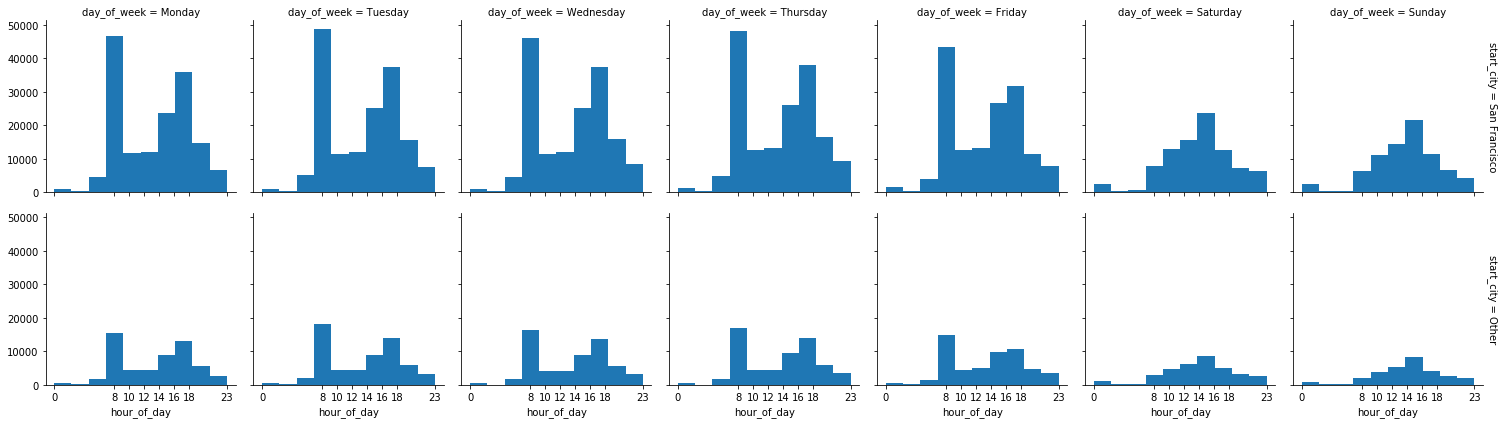

In [60]:
base_color = sb.color_palette()[0]
g = sb.FacetGrid(df, col=  'day_of_week', row= 'start_city', margin_titles = True)
g.set(xticks = [0, 8, 10, 12, 14, 16, 18, 23])
g = g.map(plt.hist, 'hour_of_day', color= base_color);

- Besides San Francisco has a larger number of usage than other cities, both groups have the same hour of day pattern for whole week.

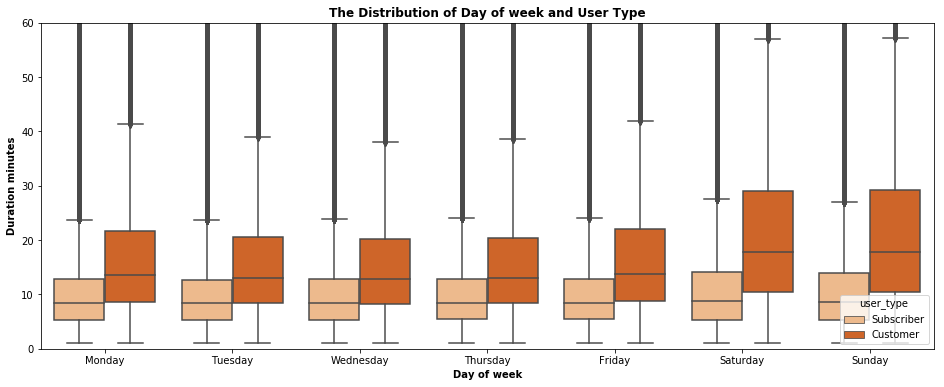

In [61]:
plt.figure(figsize = [16, 6])
sb.boxplot(data = df, x = 'day_of_week', y = 'duration_minute', hue = 'user_type', palette = 'Oranges')
plt.title('The Distribution of Day of week and User Type', fontweight ='bold')
plt.xlabel('Day of week', fontweight ='bold')
plt.ylabel('Duration minutes', fontweight ='bold')
plt.ylim(0,60);

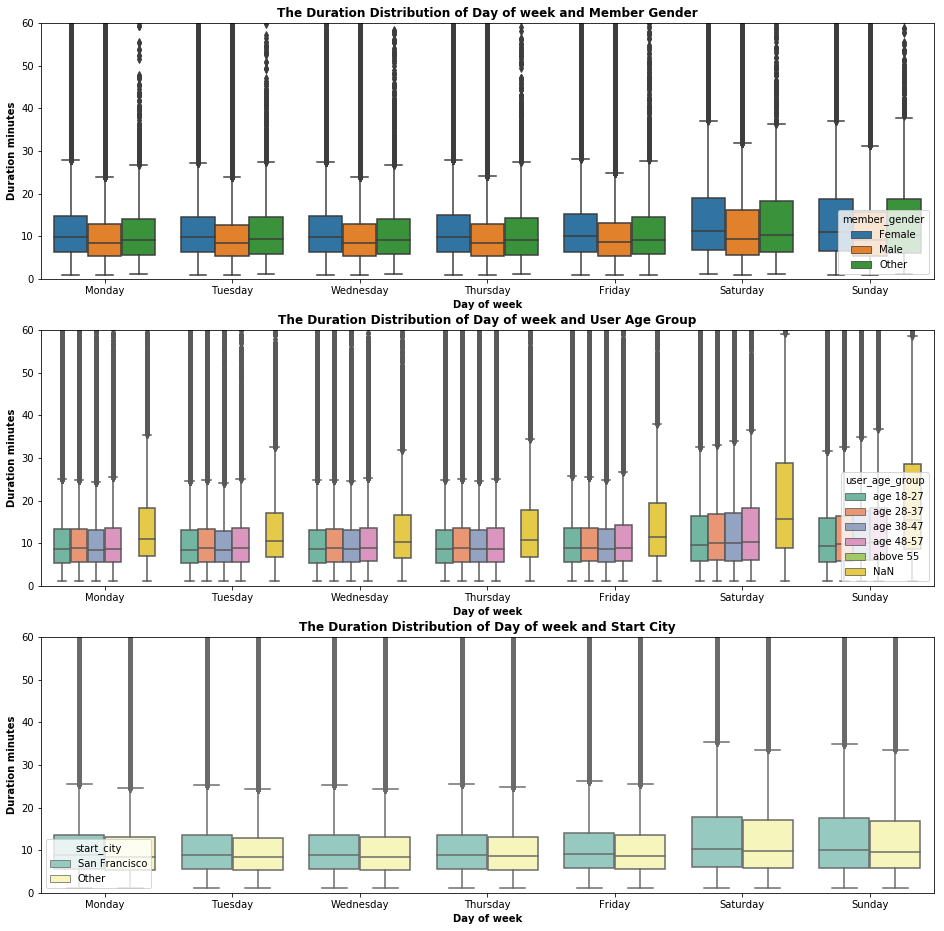

In [64]:
fig, ax = plt.subplots(nrows=3, figsize = [16,16])

sb.boxplot(data = df, x = 'day_of_week', y = 'duration_minute', hue = 'member_gender', palette = 'tab10', ax =ax[0])
ax[0].set_title('The Duration Distribution of Day of week and Member Gender', fontweight ='bold')
ax[0].set_xlabel('Day of week', fontweight ='bold')
ax[0].set_ylabel('Duration minutes', fontweight ='bold')
ax[0].set_ylim(0,60)

sb.boxplot(data = df, x = 'day_of_week', y = 'duration_minute', hue = 'user_age_group', palette = 'Set2', ax =ax[1])
ax[1].set_title('The Duration Distribution of Day of week and User Age Group', fontweight ='bold')
ax[1].set_xlabel('Day of week', fontweight ='bold')
ax[1].set_ylabel('Duration minutes', fontweight ='bold')
ax[1].set_ylim(0,60)


sb.boxplot(data = df, x = 'day_of_week', y = 'duration_minute', hue = 'start_city', palette = 'Set3', ax =ax[2])
ax[2].set_title('The Duration Distribution of Day of week and Start City', fontweight ='bold')
ax[2].set_xlabel('Day of week', fontweight ='bold')
ax[2].set_ylabel('Duration minutes', fontweight ='bold')
ax[2].set_ylim(0,60);

- User type : Surprisingly, customers tend to spend more time using a bike in average than subscribers around 10-15 minutes. Customers also have larger distributions than subscribers especially on the weekends.
- We find out there is no different of usage durations in member gender, user age group, and start town traits. All of them have the similar patterns of duration distributions; for example, all median of duration minutes is around 10 minutes.

### Conclusion

- The growth in number of rides could be affected by the weather (It dropped on November and December)
- User type trait show the significant difference in user's behaviour such as duration usage, the peak hour of day, and which day users tend to ride a bike, etc.
- Gender and user age group: Each traits likely to have the similar pattern of user's behaviour.
- Base on exploration, there is a possiblity that most users are subscribers who age around 28-37 years old. They use Ford GoBike for a transportation to a workplace (maybe because it is either cheaper or faster). Thus, it will be the peak time at 8am and 5pm, and also take only short duration per usage. It also relate to the popular start and end station which are located near the train station and the main street in the town. 